In [13]:
# Code Block 1: Import necessary libraries

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans  # For KMeans initialization
from scipy.special import logsumexp  # For numerical stability in GMM


In [14]:
# Code Block 2: Define paths and class names

# Define paths
train_dir = "../Datasets/aqueduct, industrial_area, patio data sets/train/"  # Replace with actual path
test_dir = "../Datasets/aqueduct, industrial_area, patio data sets/test/"    # Replace with actual path

# Ensure class names are sorted consistently
classes = sorted(["aqueduct", "industrial_area", "patio"])


In [15]:
# Code Block 3: Load dataset

def load_images_and_labels(folder):
    data, labels = [], []
    for class_index, class_name in enumerate(classes):
        class_path = os.path.join(folder, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            # Load image, convert to grayscale, resize, and flatten
            image = Image.open(image_path).convert("L").resize((64, 64))
            data.append(np.array(image).flatten())
            labels.append(class_index)  # Labels start from 0 for consistency
    return np.array(data), np.array(labels)

# Load train and test datasets
X_train, Y_train = load_images_and_labels(train_dir)
X_test, Y_test = load_images_and_labels(test_dir)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


Training set size: 150 samples
Testing set size: 150 samples


In [16]:
# Code Block 4: Normalize data for numerical stability

def normalize_data(train_data, test_data):
    mean = np.mean(train_data, axis=0)
    std = np.std(train_data, axis=0) + 1e-6  # Avoid division by zero
    train_norm = (train_data - mean) / std
    test_norm = (test_data - mean) / std  # Use training mean and std
    return train_norm, test_norm

X_train_norm, X_test_norm = normalize_data(X_train, X_test)


In [17]:
# Code Block 5: PCA implementation

def pca(data, n_components):
    mean_vector = np.mean(data, axis=0)
    centered_data = data - mean_vector
    # Compute covariance matrix
    covariance_matrix = np.cov(centered_data, rowvar=False)
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    # Select top n_components
    selected_vectors = eigenvectors[:, :n_components]
    # Project data onto principal components
    reduced_data = np.dot(centered_data, selected_vectors)
    return reduced_data, eigenvalues, eigenvectors, mean_vector

# Perform PCA with different values of l
l_values = [1, 2, 4, 8]
pca_results = {}
for l in l_values:
    X_train_pca, eigenvalues, eigenvectors, mean_vector = pca(X_train_norm, l)
    # Project test data using the same eigenvectors and mean
    X_test_pca = np.dot(X_test_norm - mean_vector, eigenvectors[:, :l])
    pca_results[l] = (X_train_pca, X_test_pca, Y_train, Y_test)


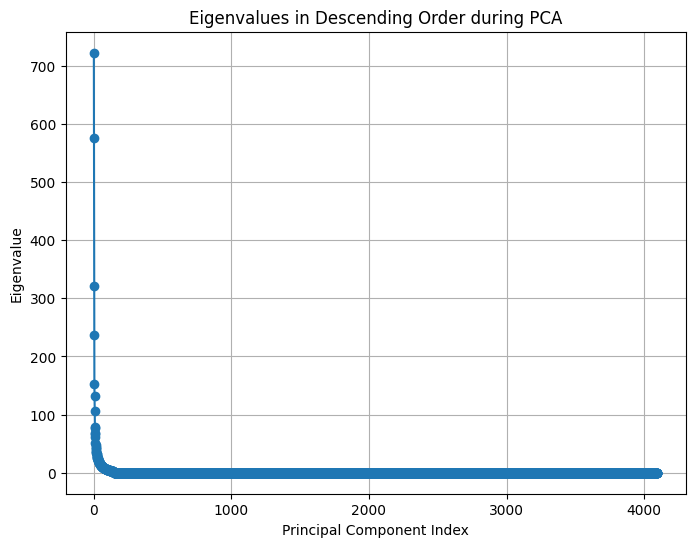

In [18]:
# Plot eigenvalues in descending order (natural order for PCA)
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.title("Eigenvalues in Descending Order during PCA")
plt.xlabel("Principal Component Index")
plt.ylabel("Eigenvalue")  
plt.grid()
plt.show()


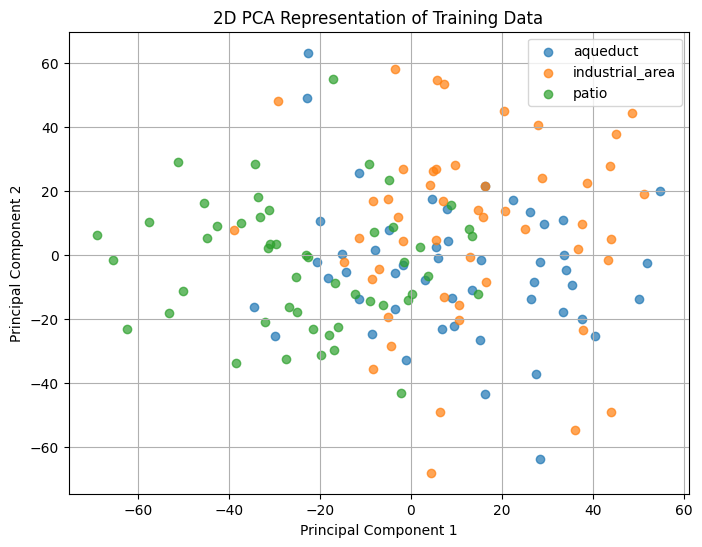

In [19]:
# Code Block 7: 2D PCA Visualization

X_train_2d, _, _, _ = pca(X_train_norm, 2)
plt.figure(figsize=(8, 6))
for label in np.unique(Y_train):
    indices = np.where(Y_train == label)
    plt.scatter(X_train_2d[indices, 0], X_train_2d[indices, 1],
                label=classes[label], alpha=0.7)
plt.title("2D PCA Representation of Training Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()


In [20]:
# Code Block 8: Compute class priors

unique, counts = np.unique(Y_train, return_counts=True)
class_priors = counts / len(Y_train)
log_class_priors = np.log(class_priors)


In [21]:
# Code Block 9: Define GMM class with numerical stability improvements

class GMM:
    def __init__(self, n_components, max_iter=100, tol=1e-3, reg_covar=1e-3):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.reg_covar = reg_covar
        self.weights = None
        self.means = None
        self.covariances = None

    def fit(self, data):
        n_samples, n_features = data.shape
        # Initialize means using KMeans
        kmeans = KMeans(n_clusters=self.n_components, n_init=5, random_state=42).fit(data)
        self.means = kmeans.cluster_centers_

        # Initialize weights and covariances
        self.weights = np.full(self.n_components, 1 / self.n_components)
        self.covariances = np.array([
            np.cov(data, rowvar=False) + np.eye(n_features) * self.reg_covar
            for _ in range(self.n_components)
        ])

        log_likelihoods = []
        for iteration in range(self.max_iter):
            # E-step
            responsibilities = self._expectation(data)
            # M-step
            self.weights, self.means, self.covariances = self._maximization(data, responsibilities)
            # Compute log likelihood
            log_likelihood = np.sum(self.score_samples(data))
            log_likelihoods.append(log_likelihood)

            # Check for convergence
            if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < self.tol:
                break

    def _expectation(self, data):
        log_prob = np.array([
            np.log(self.weights[k]) + self._log_multivariate_gaussian(data, self.means[k], self.covariances[k])
            for k in range(self.n_components)
        ])
        log_prob = np.nan_to_num(log_prob)  # Handle NaNs
        log_prob_norm = log_prob - logsumexp(log_prob, axis=0)
        responsibilities = np.exp(log_prob_norm)
        return responsibilities.T

    def _maximization(self, data, responsibilities):
        N_k = responsibilities.sum(axis=0)
        new_weights = N_k / len(data)
        new_means = np.array([
            (responsibilities[:, k][:, np.newaxis] * data).sum(axis=0) / (N_k[k] + 1e-6)
            for k in range(self.n_components)
        ])
        new_covariances = []
        for k in range(self.n_components):
            diff = data - new_means[k]
            weighted_diff = responsibilities[:, k][:, np.newaxis] * diff
            cov_k = np.dot(weighted_diff.T, diff) / (N_k[k] + 1e-6)
            # Regularize covariance matrix
            cov_k += np.eye(data.shape[1]) * self.reg_covar
            new_covariances.append(cov_k)
        return new_weights, new_means, np.array(new_covariances)

    def _log_multivariate_gaussian(self, data, mean, covariance):
        n_features = data.shape[1]
        # Ensure covariance matrix is positive-definite
        det = np.linalg.det(covariance)
        if det <= 0:
            covariance += np.eye(n_features) * self.reg_covar
            det = np.linalg.det(covariance)
        inv_cov = np.linalg.inv(covariance)
        diff = data - mean
        exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
        norm_const = -0.5 * (n_features * np.log(2 * np.pi) + np.log(det))
        return norm_const + exponent

    def score_samples(self, data):
        log_prob = np.array([
            np.log(self.weights[k]) + self._log_multivariate_gaussian(data, self.means[k], self.covariances[k])
            for k in range(self.n_components)
        ])
        log_prob = np.nan_to_num(log_prob)  # Handle NaNs
        log_prob_sum = logsumexp(log_prob, axis=0)
        return log_prob_sum


In [22]:
# Code Block 10: Train GMM models for each class

def train_gmm_models(X_train_pca, Y_train, n_components):
    models = {}
    for label in np.unique(Y_train):
        class_data = X_train_pca[Y_train == label]
        # Ensure n_components does not exceed number of samples
        n_components_adjusted = min(n_components, len(class_data))
        gmm = GMM(n_components=n_components_adjusted, reg_covar=1e-2)
        gmm.fit(class_data)
        models[label] = gmm
    return models


In [23]:
# Code Block 11: Predict using GMM models with class priors (Corrected)

def predict_gmm(models, X_test_pca, log_class_priors):
    predictions = []
    for point in X_test_pca:
        scores = {}
        for label, model in models.items():
            # Reshape point to have shape (1, n_features)
            point_reshaped = point.reshape(1, -1)
            score = model.score_samples(point_reshaped)[0] + log_class_priors[label]
            scores[label] = score
        # Predict the class with the highest score
        predicted_label = max(scores, key=scores.get)
        predictions.append(predicted_label)
    return np.array(predictions)


In [24]:
# Code Block 12: Compute confusion matrix and classification metrics

def compute_confusion_matrix(true_labels, predicted_labels, class_labels):
    n_classes = len(class_labels)
    conf_matrix = np.zeros((n_classes, n_classes), dtype=int)
    for t, p in zip(true_labels, predicted_labels):
        conf_matrix[t, p] += 1
    return conf_matrix

def compute_classification_metrics(conf_matrix):
    n_classes = conf_matrix.shape[0]
    precision, recall, f_measure = [], [], []
    for i in range(n_classes):
        tp = conf_matrix[i, i]
        fp = conf_matrix[:, i].sum() - tp
        fn = conf_matrix[i, :].sum() - tp
        class_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        class_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        class_f_measure = (2 * class_precision * class_recall) / (class_precision + class_recall) \
            if (class_precision + class_recall) > 0 else 0
        precision.append(class_precision)
        recall.append(class_recall)
        f_measure.append(class_f_measure)
    metrics = {
        "precision": precision,
        "mean_precision": np.mean(precision),
        "recall": recall,
        "mean_recall": np.mean(recall),
        "f_measure": f_measure,
        "mean_f_measure": np.mean(f_measure),
    }
    return metrics


In [25]:
# Code Block 13: Run experiments with different l and n_components

n_components_list = [1, 2, 4, 8]
results = {}

for l, (X_train_pca, X_test_pca, Y_train, Y_test) in pca_results.items():
    results[l] = {}
    for n_components in n_components_list:
        print(f"\nTraining GMM with {n_components} mixtures for PCA l={l}")
        models = train_gmm_models(X_train_pca, Y_train, n_components)
        predictions = predict_gmm(models, X_test_pca, log_class_priors)

        conf_matrix = compute_confusion_matrix(Y_test, predictions, class_labels=np.unique(Y_train))
        metrics = compute_classification_metrics(conf_matrix)

        accuracy = np.mean(predictions == Y_test)
        results[l][n_components] = {
            "accuracy": accuracy,
            "conf_matrix": conf_matrix,
            "metrics": metrics,
        }

        print(f"Accuracy: {accuracy:.4f}")
        print("Confusion Matrix:")
        print(conf_matrix)

        # Print classification metrics
        for idx, class_label in enumerate(classes):
            print(f"Class {class_label}:")
            print(f"  Precision: {metrics['precision'][idx]:.2f}")
            print(f"  Recall: {metrics['recall'][idx]:.2f}")
            print(f"  F-Measure: {metrics['f_measure'][idx]:.2f}")
        print(f"Mean Precision: {metrics['mean_precision']:.2f}")
        print(f"Mean Recall: {metrics['mean_recall']:.2f}")
        print(f"Mean F-Measure: {metrics['mean_f_measure']:.2f}")



Training GMM with 1 mixtures for PCA l=1
Accuracy: 0.5200
Confusion Matrix:
[[ 5 27 18]
 [ 7 34  9]
 [ 7  4 39]]
Class aqueduct:
  Precision: 0.26
  Recall: 0.10
  F-Measure: 0.14
Class industrial_area:
  Precision: 0.52
  Recall: 0.68
  F-Measure: 0.59
Class patio:
  Precision: 0.59
  Recall: 0.78
  F-Measure: 0.67
Mean Precision: 0.46
Mean Recall: 0.52
Mean F-Measure: 0.47

Training GMM with 2 mixtures for PCA l=1
Accuracy: 0.4867
Confusion Matrix:
[[ 6 26 18]
 [14 28  8]
 [ 1 10 39]]
Class aqueduct:
  Precision: 0.29
  Recall: 0.12
  F-Measure: 0.17
Class industrial_area:
  Precision: 0.44
  Recall: 0.56
  F-Measure: 0.49
Class patio:
  Precision: 0.60
  Recall: 0.78
  F-Measure: 0.68
Mean Precision: 0.44
Mean Recall: 0.49
Mean F-Measure: 0.45

Training GMM with 4 mixtures for PCA l=1
Accuracy: 0.4667
Confusion Matrix:
[[ 4 28 18]
 [14 28  8]
 [ 1 11 38]]
Class aqueduct:
  Precision: 0.21
  Recall: 0.08
  F-Measure: 0.12
Class industrial_area:
  Precision: 0.42
  Recall: 0.56
  F-M

In [26]:
# Code Block 14: Display results in a table format (Corrected)

import pandas as pd

# Prepare data for the table
accuracy_data = []
for l in sorted(results.keys()):
    for n_components in sorted(results[l].keys()):
        accuracy_data.append({
            'l': int(l),
            'n_components': int(n_components),
            'accuracy': results[l][n_components]['accuracy']
        })

# Create a DataFrame from the accuracy data
df_accuracy = pd.DataFrame(accuracy_data)

# Pivot the DataFrame to have 'l' as rows and 'n_components' as columns
pivot_accuracy = df_accuracy.pivot(
    index='l',
    columns='n_components',
    values='accuracy'
)

# Sort index and columns for consistent ordering
pivot_accuracy = pivot_accuracy.sort_index()
pivot_accuracy = pivot_accuracy[sorted(pivot_accuracy.columns)]

# Use apply and map instead of applymap to format the values
pivot_accuracy_formatted = pivot_accuracy.apply(
    lambda col: col.map(lambda x: f"{x * 100:.2f}%" if pd.notnull(x) else '')
)

# Display the table
print("Accuracy Results:")
print(pivot_accuracy_formatted.to_string())


Accuracy Results:
n_components       1       2       4       8
l                                           
1             52.00%  48.67%  46.67%  48.00%
2             62.00%  58.67%  48.67%  48.00%
4             66.67%  59.33%  61.33%  54.00%
8             64.00%  65.33%  54.00%  36.00%


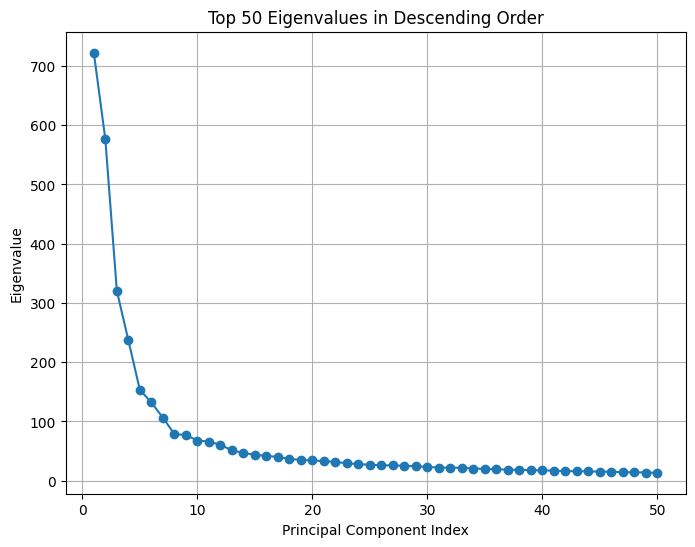

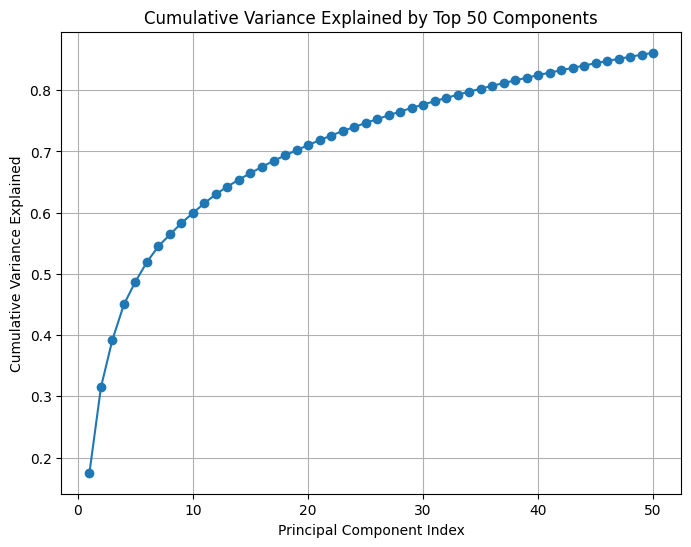

In [27]:
# Plot top 50 eigenvalues
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 51), eigenvalues[:50], marker='o')
plt.title("Top 50 Eigenvalues in Descending Order")
plt.xlabel("Principal Component Index")
plt.ylabel("Eigenvalue")
plt.grid()
plt.show()

# Plot cumulative variance explained
cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 51), cumulative_variance[:50], marker='o')
plt.title("Cumulative Variance Explained by Top 50 Components")
plt.xlabel("Principal Component Index")
plt.ylabel("Cumulative Variance Explained")
plt.grid()
plt.show()
